In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder , LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score , roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , recall_score , precision_score , f1_score , roc_auc_score , auc
from sklearn.neural_network import MLPClassifier

In [123]:
df = pd.read_csv('smoke_detection_iot.csv' , index_col=[0])

In [124]:
df.head()

,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


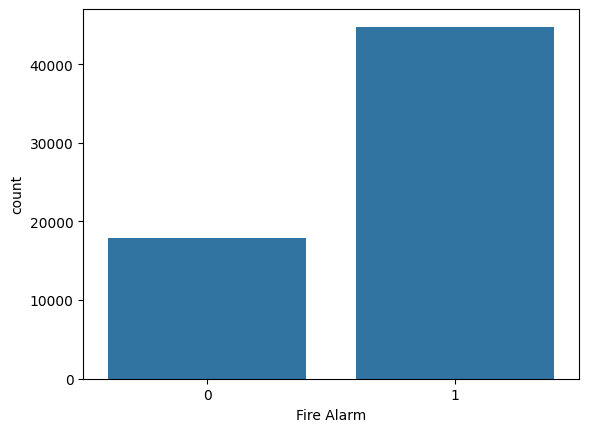

In [125]:
sns.countplot(data=df  , x='Fire Alarm')
plt.show()

In [126]:
corr = df.corr()

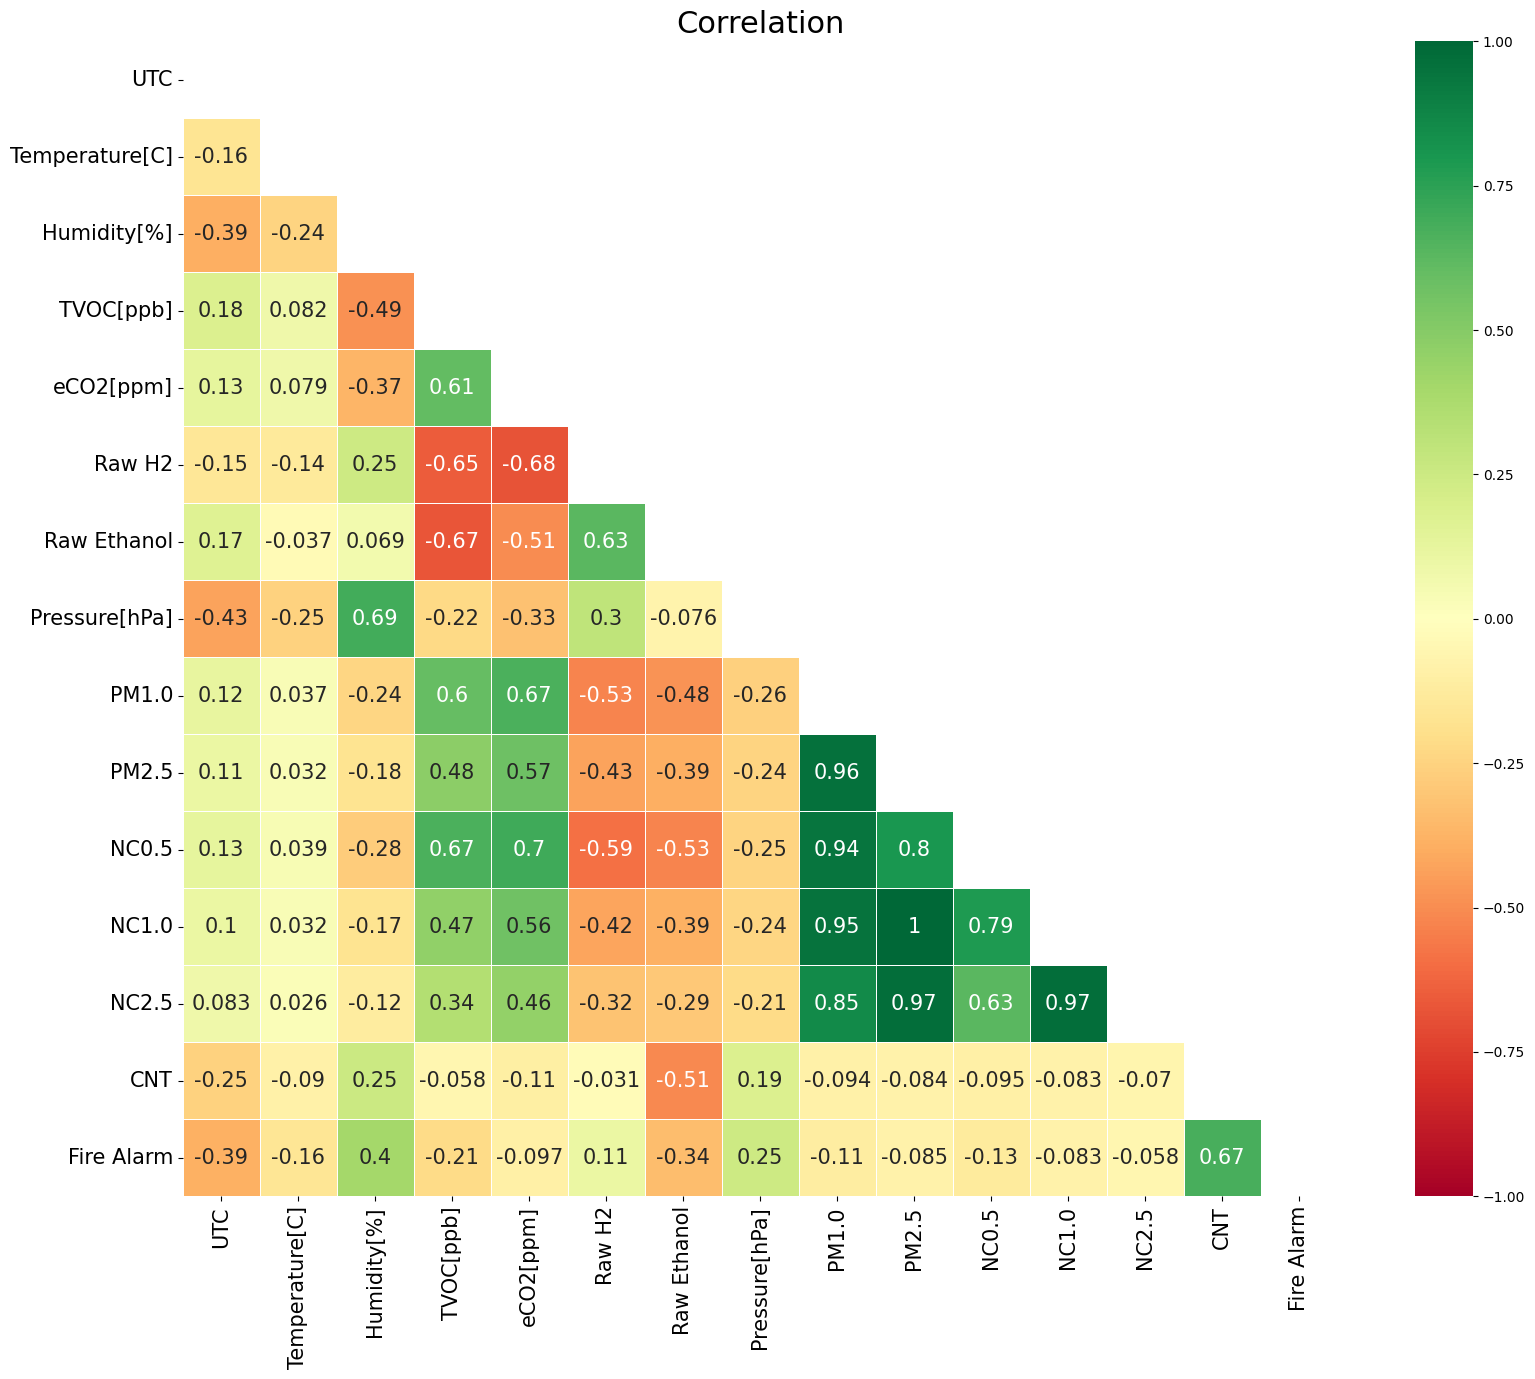

In [127]:
mask = np.zeros_like(corr , dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f , ax = plt.subplots(figsize = (20 , 15))
cmap = sns.diverging_palette(220 , 10  , as_cmap=True)
sns.heatmap(corr
            ,mask=mask
            ,cmap='RdYlGn'
            ,vmin=-1 , vmax=1
            ,center=0
            ,cbar=True
            ,annot=True
            ,square=True
            ,linewidths=.5
            ,annot_kws={'size' : 15})

plt.xticks(rotation = 90 , fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Correlation' , fontsize = 22)
plt.show()


In [128]:
X = df.iloc[: , :-1].values
y = df.iloc[: , -1].values

In [129]:
X_train , X_test , Y_train , Y_test = train_test_split(X ,y , test_size=0.2 , random_state=110)

In [130]:
sm = SMOTE()
X_smote , Y_smote = sm.fit_resample(X_train , Y_train)

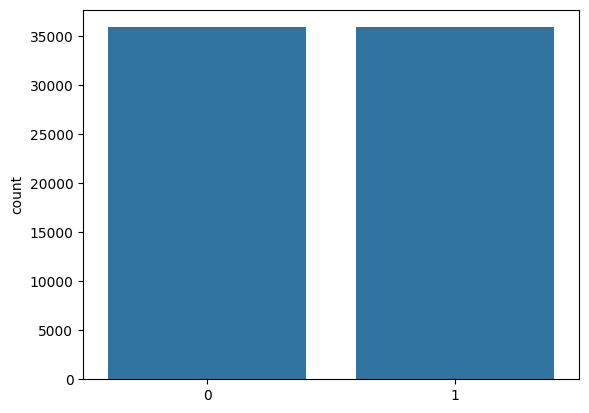

In [131]:
sns.countplot(x=Y_smote)
plt.show()

In [132]:
scaler = StandardScaler()
scaler.fit(X_smote[:])
X_smote[:] = scaler.transform(X_smote[:])
X_test[:] = scaler.transform(X_test[:])

<span style="color:#ef4444; font-weight:700; font-size:50px;">One Model Binary Classification</span>


In [133]:
result = {}
start_time = time.time()
lr = LogisticRegression()
lr.fit(X_smote , Y_smote)

Y_pred = lr.predict(X_test)
Y_prod_proba = lr.predict_proba(X_test)
training_time = time.time() - start_time

In [134]:
one_model_binary_class_results = {}

one_model_binary_class_results['LogisticRegression'] = [accuracy_score(Y_test , Y_pred)
                                                        ,precision_score(Y_test , Y_pred , average='weighted')
                                                        ,recall_score(Y_test , Y_pred , average='weighted')
                                                        ,f1_score(Y_test , Y_pred , average='weighted')
                                                        ,training_time]

In [135]:
data_result = pd.DataFrame.from_dict(one_model_binary_class_results , orient='index' , columns=["Accuracy", "Precision", "Recall", "F1-Score", "Training Time"])
data_result.sort_values(by='F1-Score' , ascending=False , na_position='first')

,Accuracy,Precision,Recall,F1-Score,Training Time
LogisticRegression,0.983874,0.984526,0.983874,0.983982,0.080484


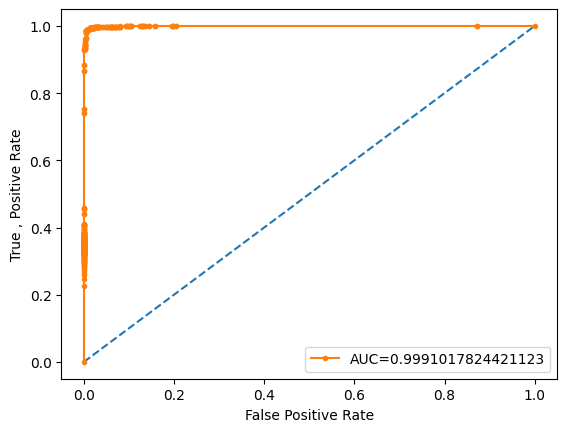

In [136]:
pos_probs = Y_prod_proba[: , 1]
plt.plot([0,1] , [0,1] , linestyle='--')
auc = roc_auc_score(Y_test , pos_probs)
fpr , tpr , _ = roc_curve(Y_test , pos_probs)
plt.plot(fpr , tpr , marker='.' , label="AUC="+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True , Positive Rate')
plt.legend()
plt.show()

<span style="color:#ef4444; font-weight:700; font-size:50px;">Multi Model Binary Classification</span>


In [137]:
models = [LogisticRegression()
          ,DecisionTreeClassifier()
          ,RandomForestClassifier()
          ,MLPClassifier()]

models_description = ["LogisticRegression"
                      ,"DecisionTreeClassifier"
                      ,"Random Forest"
                      ,"MLP"]

In [138]:

results= {}
y_probe_list = []
for index in range(len(models)):
    start_time = time.time()
    model = models[index]
    model.fit(X_smote, Y_smote)

    Y_pred = model.predict(X_test)
    Y_prod_proba = model.predict_proba(X_test)
    y_probe_list.append(Y_prod_proba)
    training_time = time.time() - start_time

    results[models_description[index]] = [accuracy_score(Y_test, Y_pred),
                                  precision_score(Y_test, Y_pred, average='weighted'),
                                  recall_score(Y_test, Y_pred, average='weighted'),
                                  f1_score(Y_test, Y_pred, average='weighted'),
                                  training_time]

In [139]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=["Accuracy", "Precision", "Recall", "F1-Score", "Training Time"] )
df_results.sort_values(by="F1-Score", ascending= False, na_position= "first")

,Accuracy,Precision,Recall,F1-Score,Training Time
Random Forest,0.999920,0.999920,0.999920,0.999920,6.285007
DecisionTreeClassifier,0.999840,0.999840,0.999840,0.999840,0.409059
MLP,0.999840,0.999840,0.999840,0.999840,4.166164
LogisticRegression,0.983874,0.984526,0.983874,0.983982,0.073446


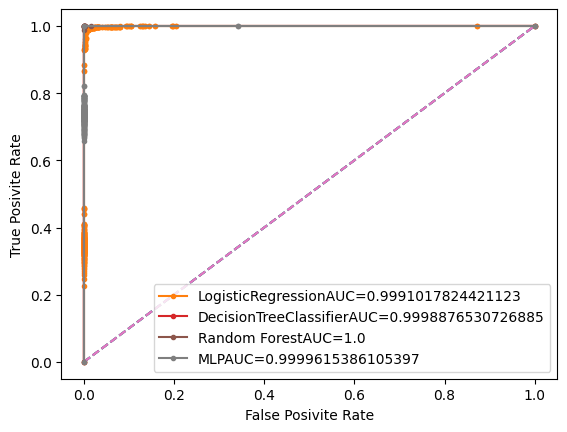

In [140]:
for index in range(4):
    pos_probs = y_probe_list[index][: , 1]
    plt.plot([0, 1], [0, 1], linestyle='--')
    auc = roc_auc_score(Y_test , pos_probs)
    fpr , tpr , _ = roc_curve(Y_test , pos_probs)
    plt.plot(fpr , tpr , marker='.' , label = models_description[index] + "AUC="+str(auc))

plt.xlabel('False Posivite Rate')
plt.ylabel('True Posivite Rate')
plt.legend()
plt.show()

<span style="color:#ef4444; font-weight:700; font-size:50px;">
One Model Multi Label Classification</span>


In [141]:
data = pd.read_csv('Iris.csv' , sep="," , header=0 , names=["sepal_length","sepal_weight","petal_length","petal_width","class_name"])
data.head()

,sepal_length,sepal_weight,petal_length,petal_width,class_name
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [142]:
le = LabelEncoder()
data['class'] = le.fit_transform(data['class_name'])

In [143]:
X = data.iloc[: , :-2].values
Y = data.iloc[: , -1].values

In [144]:
X_train , X_test , Y_train , Y_test = train_test_split(X , Y , test_size=0.2 , random_state=110)

In [156]:
bolum3_result = {}
start_time = time.time()
lr = LogisticRegression()
lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)
iris_proba = lr.predict_proba(X_test)

bolum3_result["Logistic Regression"] = [accuracy_score(Y_test, Y_pred),
                                  precision_score(Y_test, Y_pred, average='weighted'),
                                  recall_score(Y_test, Y_pred, average='weighted'),
                                  f1_score(Y_test, Y_pred, average='weighted'),
                                  training_time]

In [157]:
df_results = pd.DataFrame.from_dict(bolum3_result , orient='index' , columns=["Accuracy", "Precision", "Recall", "F1-Score", "Training Time"])
df_results.sort_values(by='F1-Score' , ascending=False , na_position='first')

,Accuracy,Precision,Recall,F1-Score,Training Time
Logistic Regression,0.966667,0.968519,0.966667,0.964762,4.166164


In [158]:
data.class_name.unique().tolist()

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

ROC AUC score: 0.9455128205128206


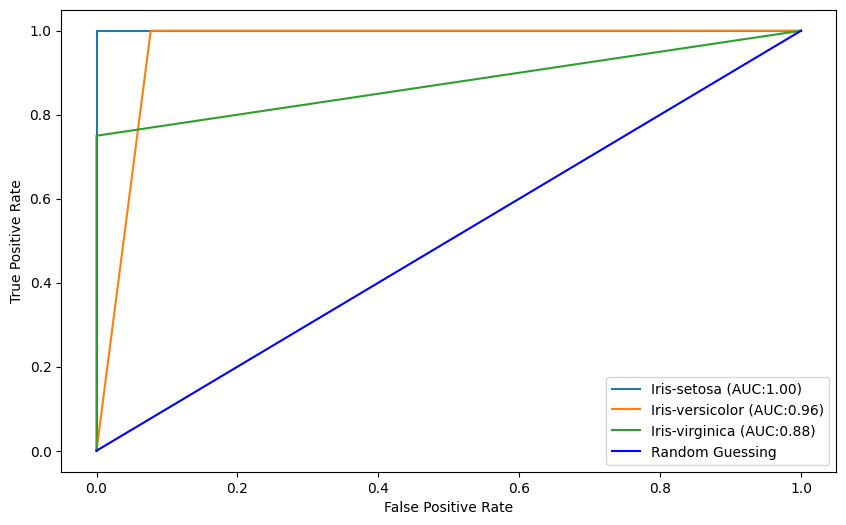

In [159]:
target= lr.classes_.tolist()
data_str = data.class_name.unique()
fig, c_ax = plt.subplots(1,1, figsize = (10, 6))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):

    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)


    for (idx, c_label) in enumerate(target):

        fpr, tpr, thresholds = roc_curve(y_test[:,idx], y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (data_str[c_label], auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(Y_test, Y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()